In [49]:
import numpy as np
import librosa
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import soundfile as sf
# from mystft import stft, istft, extract_frames, overlapadd

import sys
import os
# Add upper directory
current_dir = os.path.dirname(os.path.abspath('demo_TSM.ipynb'))
upper_dir = (os.path.join(current_dir, '..'))
sys.path.append(upper_dir)
from utils_global import draw_spec

### Previously Implemented Functions

In [50]:
""" 
** extract_frames()
** stft()
** overlapadd()
** istft()
Refer to STFT, OLA(Griffin Lim's Algorithm), ISTFT 
  """
def extract_frames(y, win_type='hamming', win_length=320, hop_length=160,):
    """ 
    Extract frames identical to librosa STFT 
    ** Returns:
        frame list that contations every time-domain frames
    """
    if win_length < hop_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to hop_length ({hop_length})")
    if win_length < win_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to win_length ({win_length})")
    
    y = np.pad(y, (win_length//2, win_length//2), mode='constant', constant_values=0)  # padding
    siglen_pad = len(y)  # Length of the padded signal

    # window
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")

    frame_list = []
    # Frame processing
    for center in range(win_length//2, siglen_pad, hop_length):
        if center > siglen_pad - win_length//2:
            break #end condition
        start = center - win_length//2
        end = center + win_length//2
        frame = y[start:end]
        frame = frame * window
        frame_list.append(frame)
    return frame_list

def stft(y, sr=16000, win_type='hamming', win_length=320, hop_length=160, n_fft=None,
         pad_mode='constant', figsize=(14, 4), cmap='viridis', 
        #  vmin=-50, vmax=40,
         use_colorbar=True, plot=False, return_fig=False):
    
    """ 
    STFT Implementation identical to librosa.stft 
    This implementation is based on center=='True' option
    ** Returns:
        spec: Magnitude spectrogram (NFFT//2+1 x Frames).
        Returns the figure if `return_fig` is True.
    """
    if not n_fft:
        n_fft = win_length
    
    if win_length < hop_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to hop_length ({hop_length})")
    if n_fft < win_length:
        raise ValueError(f"n_fft ({n_fft}) must be greater than or equal to win_length ({win_length})")
    
    siglen_sec = len(y)/sr
    y = np.pad(y, (n_fft//2, n_fft//2), mode=pad_mode, constant_values=0)  # padding
    siglen_pad = len(y)  # Length of the padded signal

    # window
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")

    spec = []
    # Frame processing
    for center in range(n_fft//2, siglen_pad, hop_length):
        if center > siglen_pad - n_fft//2:
            break #end condition

        start = center - win_length//2
        end = center + win_length//2
        frame = y[start:end]
        frame = frame * window

        # pad until n_fft       
        padlen = n_fft - len(frame)
        frame = np.pad(frame, pad_width=[padlen//2, padlen//2], mode='constant')
        frame_fft = np.fft.fft(frame)[:n_fft//2 + 1]
        spec.append(frame_fft)

    spec = np.array(spec).T  # [freq x timeframe]
    # spec = np.abs(spec)

    # Plot option
    if plot:
        fig = plt.figure(figsize=figsize)
        plt.imshow(np.abs(spec), aspect='auto', 
                   cmap=cmap, 
                #    vmin=vmin, vmax=vmax,
                   origin='lower', extent=[0, siglen_sec, 0, sr//2])

        if use_colorbar: plt.colorbar()
        plt.title("STFT Spectrogram")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

        if return_fig:
            plt.close()
            return spec, fig
        else:
            plt.show()
            return spec
    else:
        return spec

def overlapadd(frames, win_length, hop_length, win_type='hann', griffin=True):
    """ 
    OLA process and implementation of LSEE-MSTFT (Griffin Lim's)
    input: 
        frames: frame list with [NumFrames]
        win_type: Window array or string type of window
    """
    num_frames = len(frames)
    siglen = win_length + (num_frames - 1) * hop_length
    y = np.zeros(siglen)
    window_sum = np.zeros(siglen)
    
    # Generate window if win_type is a string; otherwise, use the provided array
    if isinstance(win_type, str):
        try:
            window = librosa.filters.get_window(win_type, win_length)
        except ValueError:
            raise ValueError("Unsupported window type!")
    else:
        window = win_type  # Assume win_type is already an array with proper padding
    
    for frame_idx in range(num_frames):
        start = frame_idx * hop_length
        frame = frames[frame_idx]
        if griffin:
            y[start:start + win_length] += frame * window
            window_sum[start:start + win_length] += window ** 2
        else:
            y[start:start+win_length] += frame
            window_sum[start:start+win_length] += window
    
    # Normalize by window overlap factor
    y /= np.where(window_sum > 1e-10, window_sum, 1e-10)

    # crop out to remove paddings (center-based STFT)
    y = y[win_length//2:-win_length//2]
    window_sum = window_sum[win_length//2:-win_length//2]
    return y

def istft(Y_w, win_length, hop_length, n_fft, win_type='hann', griffin=True):
    """
    ISTFT Implementation identical to librosa.istft     
    ** Returns:
        y_buffer: Reconstructed time-domain signal
    """
    if not n_fft:
        n_fft = win_length  # Default to win_length if n_fft is not provided
        
    if win_length < hop_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to hop_length ({hop_length})")
    if n_fft < win_length:
        raise ValueError(f"n_fft ({n_fft}) must be greater than or equal to win_length ({win_length})")

    # Generate window with padding if win_length < n_fft
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")
    padlen = n_fft - win_length
    padded_window = np.pad(window, (padlen // 2, padlen // 2), mode='constant')

    # Reconstruct Y to get full spectrum in frequency axis
    Y_flip = np.flipud(Y_w)[1:-1]
    Y_w = np.concatenate((Y_w, np.conj(Y_flip)), axis=0)  # Note that phase is odd
    
    num_frames = Y_w.shape[1]
    frames = []

    # Calculate each frame by inverse FFT
    for frame_idx in range(num_frames):
        frame = np.real(np.fft.ifft(Y_w[:, frame_idx]))  # Inverse FFT
        frames.append(frame)
    
    # OLA
    y_buffer = overlapadd(frames, win_length=n_fft, hop_length=hop_length, win_type=padded_window, griffin=griffin)
    return y_buffer


### Griffin Lim's Algorithm
#### LSEE-MSTFT, LSEE-MSTFTM

In [51]:
import numpy as np
import librosa

def SER(original_magnitude, reconstructed_magnitude, epsilon=0):
    """
    Calculate Spectral Error Ratio (SER) in dB.
    
    Parameters:
        original_magnitude (np.ndarray): Original magnitude spectrogram (|Y_w|)
        reconstructed_magnitude (np.ndarray): Reconstructed magnitude spectrogram (|X_w|)
    
    Returns:
        float: SER value in dB
    """
    # Calculate the energy of the original magnitude in the numerator
    original_energy = np.sum(original_magnitude ** 2)
    
    # Calculate the squared error in the denominator
    error = np.sum((original_magnitude - reconstructed_magnitude) ** 2)
    
    if error ==0:
        return -250 # -infty(-250dB) for zero error
    
    # Compute SER in dB
    ser_value = 10 * np.log10(original_energy / (error+epsilon))
    
    return ser_value

def LSEE_MSTFTM(stftm, win_length, hop_length, n_fft, num_iterations=50, win_type='hann', griffin=True, verbose=True):
    """
    LSEE-MSTFTM: Least-Squares Error Estimate for Modified Short-Time Fourier Transform Magnitude
    Iteratively estimates phase spectra from magnitude spectra
    ** Inputs:
        stftm: given magnitude spectrogram (|Y|) 
        win_length: Window length
        hop_length: Hop length
        n_fft: FFT size
        num_iterations: Number of iterations for phase reconstruction
        win_type: Type of window (default 'hann')
    ** Returns:
        y_reconstructed: Reconstructed time-domain signal
    """
    
    # Step 1: Initialize 
    y_initial = istft(stftm, win_length=win_length, hop_length=hop_length, n_fft=n_fft, win_type=win_type, griffin=griffin)
    # y_initial = np.random.normal(0,1,y_initial.shape) # Gaussian initialization
    
    for i in range(num_iterations):
        # Step 2: Compute STFT of the current time-domain signal
        Y = librosa.stft(y_initial, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=win_type)

        # Step 3: Replace magnitude with given stftm and retain phase
        Y_phase = np.angle(Y)
        Y_new = stftm * np.exp(1j * Y_phase)
        
        # SER
        current_magnitude = np.abs(Y)
        ser_value = SER(stftm, current_magnitude)
        if verbose:
            print(f"Iteration {i}/{num_iterations}, SER: {ser_value:.2f} dB")
        
        # Step 4: Perform ISTFT to get the updated time-domain signal
        y_initial = istft(Y_new, win_length=win_length, hop_length=hop_length, n_fft=n_fft, win_type=win_type, griffin=griffin)
        
    # Final SER
    Y_final = librosa.stft(y_initial, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=win_type)
    final_magnitude = np.abs(Y_final)
    final_ser_value = SER(stftm, final_magnitude)
    print(f"Final SER after {num_iterations} iterations: {final_ser_value:.2f} dB")

    return y_initial

Original signal length: 85335
Iteration 0/30, SER: 0.04 dB
Iteration 1/30, SER: 5.21 dB
Iteration 2/30, SER: 9.37 dB
Iteration 3/30, SER: 11.86 dB
Iteration 4/30, SER: 13.20 dB
Iteration 5/30, SER: 13.93 dB
Iteration 6/30, SER: 14.42 dB
Iteration 7/30, SER: 14.80 dB
Iteration 8/30, SER: 15.12 dB
Iteration 9/30, SER: 15.39 dB
Iteration 10/30, SER: 15.64 dB
Iteration 11/30, SER: 15.87 dB
Iteration 12/30, SER: 16.09 dB
Iteration 13/30, SER: 16.29 dB
Iteration 14/30, SER: 16.49 dB
Iteration 15/30, SER: 16.68 dB
Iteration 16/30, SER: 16.86 dB
Iteration 17/30, SER: 17.03 dB
Iteration 18/30, SER: 17.20 dB
Iteration 19/30, SER: 17.36 dB
Iteration 20/30, SER: 17.52 dB
Iteration 21/30, SER: 17.67 dB
Iteration 22/30, SER: 17.81 dB
Iteration 23/30, SER: 17.95 dB
Iteration 24/30, SER: 18.08 dB
Iteration 25/30, SER: 18.21 dB
Iteration 26/30, SER: 18.33 dB
Iteration 27/30, SER: 18.45 dB
Iteration 28/30, SER: 18.56 dB
Iteration 29/30, SER: 18.68 dB
Final SER after 30 iterations: 18.79 dB
Original sign

Reconstructed signal (implemented LSEE-MSTFTM):


Reconstructed signal (librosa):


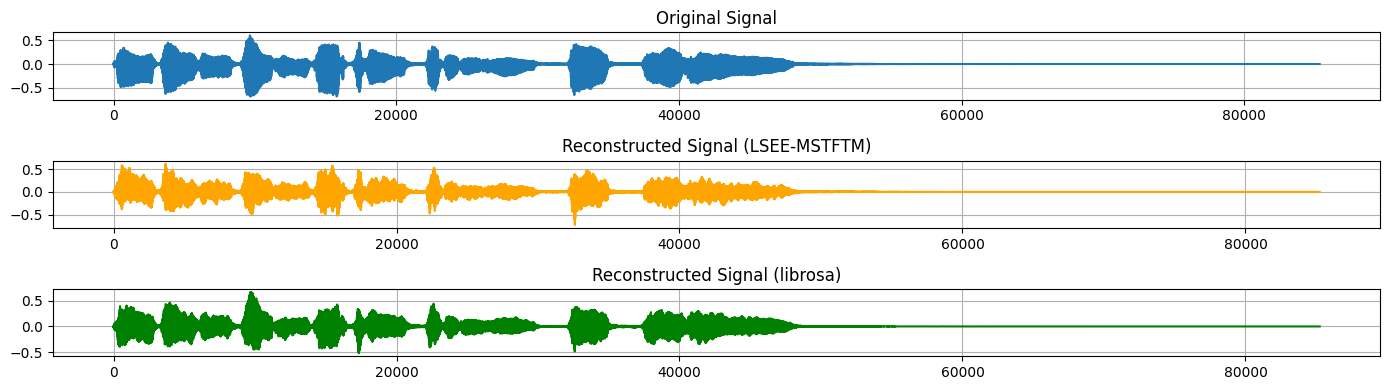

In [52]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

y, sr = librosa.load(librosa.ex('trumpet'), sr=16000)
# y,sr = librosa.load('/home/woongjib/Projects/24-2_SSP/HW3/s5_180_mic1.flac', sr=None)

print(f"Original signal length: {len(y)}")

# STFT parameters
n_fft = 1024
win_length = 512
hop_length = 256
win_type = 'hann'

# Step 1: Extract magnitude spectra
Y = librosa.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=win_type)
magnitude_spectrogram = np.abs(Y) 

# Step 2: Reconstruct the signal from STFTM, using LSEE-MSTFTM
num_iterations = 30
y_reconstructed = LSEE_MSTFTM(magnitude_spectrogram, win_length, hop_length, n_fft, num_iterations=num_iterations, win_type=win_type, griffin=True)
y_librosa = librosa.griffinlim(magnitude_spectrogram, hop_length=hop_length, win_length=win_length, window=win_type) # Librosa reference

# Compare the original and reconstructed signals
print("Original signal:")
display(Audio(y, rate=sr))
print("Reconstructed signal (implemented LSEE-MSTFTM):")
display(Audio(y_reconstructed, rate=sr))
print("Reconstructed signal (librosa):")
display(Audio(y_librosa, rate=sr))

# Plot
plt.figure(figsize=(14, 4))
plt.subplot(3, 1, 1)
plt.plot(y, label='Original Signal')
plt.title('Original Signal')
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(y_reconstructed, color='orange', label='Reconstructed Signal')
plt.title('Reconstructed Signal (LSEE-MSTFTM)')
plt.grid()
plt.tight_layout()
plt.subplot(3, 1, 3)
plt.plot(y_librosa, color='green', label='Reconstructed Signal')
plt.title('Reconstructed Signal (librosa)')
plt.grid()
plt.tight_layout()
plt.show()


### Time Scale Modification

#### Comparison of STFTM for time scale modified signal

Original signal length: 32192


Increased sampling frequency (w/o TSM): 


Librosa library:


Implemented TSM:
Final SER after 400 iterations: 16.00 dB


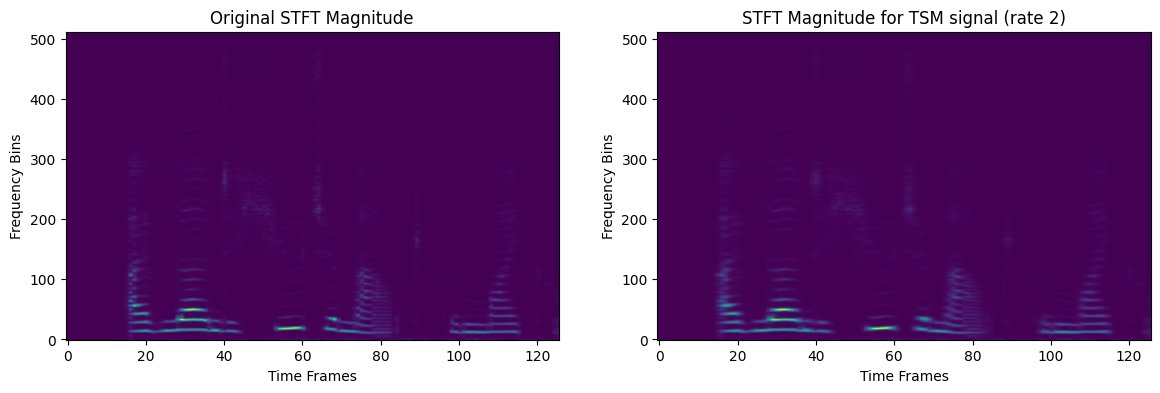

In [53]:
""" Concept of TSM in spectral domain """
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Parameters
hop_length = 256
win_length = 512
n_fft = 1024
rate = 2

# Load audio
y, sr = librosa.load('/home/woongjib/Projects/24-2_SSP/HW3/s5_180_mic1.flac', sr=None)
print(f"Original signal length: {len(y)}")
display(Audio(y,rate=sr))

print(f"Increased sampling frequency (w/o TSM): ")
display(Audio(y,rate=sr*rate))

# STFT calculation (using librosa or custom stft)
D = stft(y, n_fft=n_fft, win_type='hamming', win_length=win_length, hop_length=hop_length, plot=False)
stftm = np.abs(D)

print("Librosa library:")
# y_inv = librosa.istft(stftm, win_length=win_length, hop_length=hop_length, window='hamming', n_fft=n_fft,)
# display(Audio(y_inv, rate=sr))
y_fast = librosa.griffinlim(stftm, hop_length=hop_length//rate, win_length=win_length, window='hamming')
display(Audio(y_fast, rate=sr))
print("Implemented TSM:")
y_reconstructed = LSEE_MSTFTM(stftm, win_length=win_length, hop_length=hop_length//rate, win_type='hamming', n_fft=n_fft, griffin=True, verbose=False, num_iterations=400)
display(Audio(y_reconstructed, rate=sr))

D_tsm = stft(y_reconstructed, n_fft=n_fft, win_length=win_length, hop_length=hop_length//rate)
mstftm = np.abs(D_tsm)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Original STFT Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.imshow(stftm, aspect='auto', origin='lower', cmap='viridis')
# plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
plt.title("STFT Magnitude for TSM signal (rate 2)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.imshow(mstftm, aspect='auto', origin='lower', cmap='viridis')
# plt.colorbar(format='%+2.0f dB')
plt.show()


#### Implementation
- SOLA
- LSEE-MSTFTM based TSM

In [54]:
""" LSEE-MSTFTM for Time Scale Modification """
from mystft import extract_frames
import numpy as np

def SynchronousOLA(frames, win_length, hop_length, win_type='hann', max_shift=130, visualize=True):
    """
    SOLA (Synchronous Overlap-Add) function for frame-based synthesis.
    ** Inputs:
        frames: List of frames to be combined.
        win_length: Window length for each frame.
        hop_length: Hop length for original signal synthesis.
        win_type: Window type (default 'hann') or a window array.
        max_shift: Maximum allowed shift for alignment (in samples).
    ** Returns:
        y: Reconstructed signal using SOLA.
    """
    num_frames = len(frames)
    siglen = win_length + (num_frames - 1) * hop_length
    y = np.zeros(siglen)
    window_sum = np.zeros(siglen)

    # window
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")

    # visualization options
    vis_range=(22,25)
    vis_a, vis_b = vis_range  
    plot_count = vis_b - vis_a + 1
    if plot_count > 0:
        fig, axes = plt.subplots(1, plot_count, figsize=(plot_count * 5, 5))
        if plot_count == 1:
            axes = [axes]

    # Overlap Add
    for frame_idx in range(num_frames):
        start = frame_idx * hop_length
        frame = frames[frame_idx]
        
        if frame_idx == 0:
            # First frame is added normally
            y[start:start + win_length] += frame * window
            window_sum[start:start + win_length] += window ** 2
        else:
            overlap_start = start
            overlap_end = start + win_length
            existing_segment = y[overlap_start:overlap_end]

            # Calculate cross-correlation and find the best shift
            correlations = np.correlate(existing_segment, frame, mode='full')
            max_idx = np.argmax(correlations[len(correlations)//2 - max_shift:len(correlations)//2 + max_shift + 1])
            best_shift = max_idx - max_shift

            # visualization options
            if visualize and vis_a <= frame_idx <= vis_b:
                ax = axes[frame_idx - vis_a]
                ax.plot(existing_segment, label='Existing Segment')
                ax.plot(frame, label='Original Frame (No Shift)', linestyle='dotted')
                ax.plot(np.roll(frame, best_shift), label=f'Shifted Frame (Best Shift={best_shift})', linestyle='dashed')
                ax.set_title(f'Frame {frame_idx}: OLA')
                ax.set_xlabel('Sample Index')
                ax.set_ylabel('Amplitude')
                ax.legend(loc='upper right')
                ax.grid(True)
                
            # Apply best shift and combine the frame
            shifted_frame = np.roll(frame, best_shift)
            y[overlap_start:overlap_end] += shifted_frame * window
            window_sum[overlap_start:overlap_end] += window ** 2

    # Normalize
    y /= np.where(window_sum > 1e-10, window_sum, 1e-10)

    # Crop out to remove paddings (if center-based STFT was used)
    y = y[win_length // 2:-win_length // 2]
    return y

def LSEE_TSM(y, rate=2, hop_length=256, win_length=512, win_type='hamming', num_iterations=50, 
             verbose=True, griffin=True, initial='gaussian', return_ser=False):
    from fractions import Fraction
    """
    Time-Scale Modification using LSEE-MSTFTM for phase reconstruction.
    ** Inputs:
        y: Original input signal
        rate: Time-scaling factor (e.g., rate=2 means 2x speed-up)
        hop_length: Hop length for the original signal STFT
        win_length: Window length
        win_type: Window type (default 'hamming')
        num_iterations: Number of iterations for phase reconstruction
        verbose: Print SER at each iteration
    ** Returns:
        x_reconstructed: Time-scaled and phase-reconstructed signal
    """
    n_fft = win_length
    Sa = hop_length 
    Ss = int(np.round(Sa / rate))  

    # Length adjustment
    frac_rate = Fraction(rate).limit_denominator()
    n = frac_rate.numerator
    y_len = (len(y) // n) * n 
    y = y[:y_len]
    
    # STFTM of original
    Y = np.abs(stft(y, n_fft=n_fft, win_type=win_type, win_length=win_length, hop_length=Sa, plot=False))
    if verbose: print(f"STFT of original signal (shape): {Y.shape}") 
    
    # Initial estmiate of TSM signal
    x_len = int(len(y) / rate)
    if initial == 'gaussian':
        x_initial = np.random.normal(0, 1, x_len)  
    elif initial  == 'sola':
        ################################### Key implementations ###################################
        frames = extract_frames(y, win_type=win_type, win_length=win_length, hop_length=Sa)
        x_initial = SynchronousOLA(frames, win_length=win_length, hop_length=Ss, win_type=win_type)
        ################################### Key implementations ###################################
    elif initial == 'zero_phase':
        X = Y
    else: 
        raise ValueError(f"Unsupported initial method: {initial}")
    
    ser_list = []
    for i in range(num_iterations):
        # Compute STFT of the current time-domain signal x
        if initial != 'zero_phase' or i > 0:
            X = stft(x_initial, n_fft=n_fft, hop_length=Ss, win_length=win_length, win_type=win_type)

        # Replace magnitude into STFTM (Y)
        if X.shape[1] == Y.shape[1]:
            X_phase = np.angle(X)
            X_new = Y * np.exp(1j * X_phase)
        else:
            raise ValueError(f"Mismatch in STFT frame count. {X.shape[1]}<>{Y.shape[1]} Please adjust the rate or signal length.")

        # Calculate SER (Spectral Error Ratio)
        current_magnitude = np.abs(X)
        ser_value = SER(Y, current_magnitude)
        ser_list.append(ser_value)
        if verbose:
            print(f"Iteration {i}/{num_iterations}, SER: {ser_value:.2f} dB")

        # ISTFT (OLA) and update the estimate
        x_initial = istft(X_new, win_length=win_length, hop_length=Ss, n_fft=n_fft, win_type=win_type, griffin=griffin)
    final_ser_value = SER(Y, np.abs(librosa.stft(x_initial, n_fft=n_fft, hop_length=Ss, win_length=win_length, window=win_type)))
    print(f"Final SER after {num_iterations} iterations: {final_ser_value:.2f} dB")
    ser_list.append(final_ser_value)

    if return_ser:
        return x_initial, ser_list
    else:
        return x_initial

Original signal length: 32192


Without TSM:


Librosa Library TSM:


STFT of original signal (shape): (257, 126)
Iteration 0/100, SER: -24.24 dB
Iteration 1/100, SER: 7.14 dB
Iteration 2/100, SER: 8.69 dB
Iteration 3/100, SER: 9.56 dB
Iteration 4/100, SER: 10.27 dB
Iteration 5/100, SER: 10.92 dB
Iteration 6/100, SER: 11.50 dB
Iteration 7/100, SER: 12.00 dB
Iteration 8/100, SER: 12.38 dB
Iteration 9/100, SER: 12.66 dB
Iteration 10/100, SER: 12.87 dB
Iteration 11/100, SER: 13.04 dB
Iteration 12/100, SER: 13.17 dB
Iteration 13/100, SER: 13.28 dB
Iteration 14/100, SER: 13.39 dB
Iteration 15/100, SER: 13.49 dB
Iteration 16/100, SER: 13.57 dB
Iteration 17/100, SER: 13.65 dB
Iteration 18/100, SER: 13.71 dB
Iteration 19/100, SER: 13.78 dB
Iteration 20/100, SER: 13.86 dB
Iteration 21/100, SER: 13.96 dB
Iteration 22/100, SER: 14.08 dB
Iteration 23/100, SER: 14.23 dB
Iteration 24/100, SER: 14.40 dB
Iteration 25/100, SER: 14.54 dB
Iteration 26/100, SER: 14.65 dB
Iteration 27/100, SER: 14.73 dB
Iteration 28/100, SER: 14.79 dB
Iteration 29/100, SER: 14.84 dB
Iteratio

STFT of original signal (shape): (257, 126)
Iteration 0/100, SER: -250.00 dB
Iteration 1/100, SER: 1.25 dB
Iteration 2/100, SER: 5.83 dB
Iteration 3/100, SER: 7.81 dB
Iteration 4/100, SER: 8.91 dB
Iteration 5/100, SER: 9.50 dB
Iteration 6/100, SER: 9.88 dB
Iteration 7/100, SER: 10.14 dB
Iteration 8/100, SER: 10.33 dB
Iteration 9/100, SER: 10.48 dB
Iteration 10/100, SER: 10.62 dB
Iteration 11/100, SER: 10.75 dB
Iteration 12/100, SER: 10.89 dB
Iteration 13/100, SER: 11.03 dB
Iteration 14/100, SER: 11.19 dB
Iteration 15/100, SER: 11.38 dB
Iteration 16/100, SER: 11.61 dB
Iteration 17/100, SER: 11.84 dB
Iteration 18/100, SER: 12.06 dB
Iteration 19/100, SER: 12.27 dB
Iteration 20/100, SER: 12.47 dB
Iteration 21/100, SER: 12.64 dB
Iteration 22/100, SER: 12.80 dB
Iteration 23/100, SER: 12.97 dB
Iteration 24/100, SER: 13.17 dB
Iteration 25/100, SER: 13.37 dB
Iteration 26/100, SER: 13.55 dB
Iteration 27/100, SER: 13.69 dB
Iteration 28/100, SER: 13.80 dB
Iteration 29/100, SER: 13.89 dB
Iteration 

STFT of original signal (shape): (257, 126)
Iteration 0/100, SER: 8.46 dB
Iteration 1/100, SER: 12.45 dB
Iteration 2/100, SER: 13.63 dB
Iteration 3/100, SER: 14.21 dB
Iteration 4/100, SER: 14.53 dB
Iteration 5/100, SER: 14.74 dB
Iteration 6/100, SER: 14.88 dB
Iteration 7/100, SER: 14.98 dB
Iteration 8/100, SER: 15.08 dB
Iteration 9/100, SER: 15.16 dB
Iteration 10/100, SER: 15.23 dB
Iteration 11/100, SER: 15.29 dB
Iteration 12/100, SER: 15.34 dB
Iteration 13/100, SER: 15.38 dB
Iteration 14/100, SER: 15.42 dB
Iteration 15/100, SER: 15.45 dB
Iteration 16/100, SER: 15.48 dB
Iteration 17/100, SER: 15.50 dB
Iteration 18/100, SER: 15.53 dB
Iteration 19/100, SER: 15.55 dB
Iteration 20/100, SER: 15.57 dB
Iteration 21/100, SER: 15.59 dB
Iteration 22/100, SER: 15.60 dB
Iteration 23/100, SER: 15.62 dB
Iteration 24/100, SER: 15.64 dB
Iteration 25/100, SER: 15.65 dB
Iteration 26/100, SER: 15.66 dB
Iteration 27/100, SER: 15.68 dB
Iteration 28/100, SER: 15.69 dB
Iteration 29/100, SER: 15.70 dB
Iterati

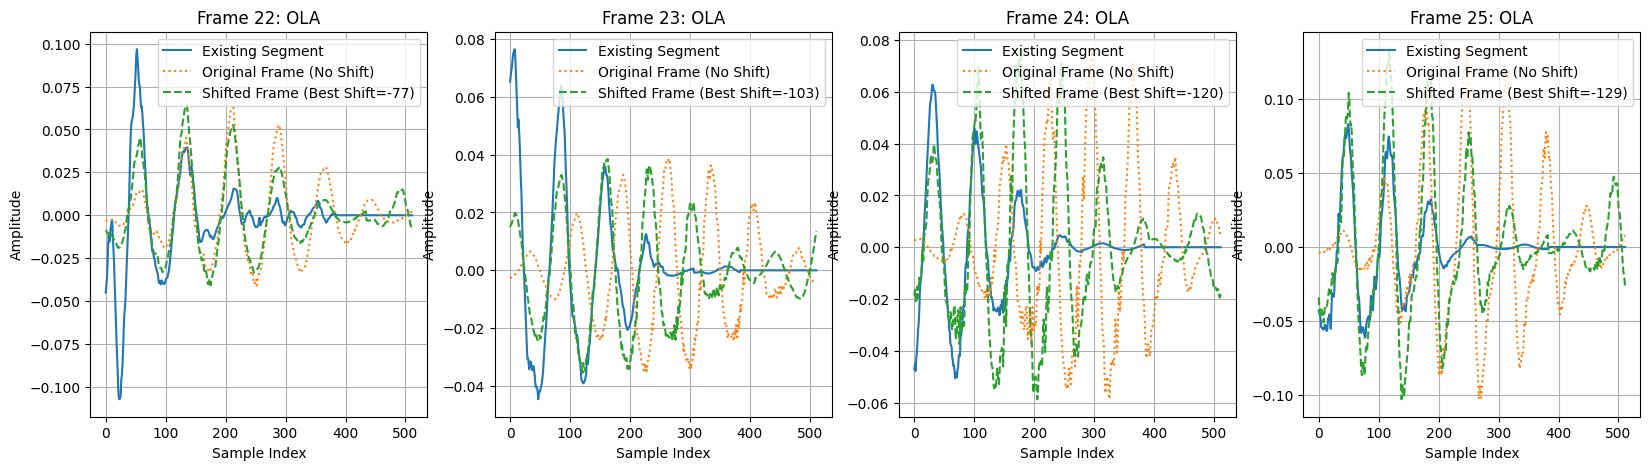

In [55]:
# Parameters
hop_length = 256
win_length = 512
n_fft = 1024
rate = 2

# Load audio
y, sr = librosa.load('/home/woongjib/Projects/24-2_SSP/HW3/s5_180_mic1.flac', sr=None)
# y, sr = librosa.load('/home/woongjib/Projects/24-2_SSP/HW3/sample_crop_16kHz.wav', sr=None)
# y, sr = librosa.load('/home/woongjib/Projects/24-2_SSP/HW3/s5_001_mic1.flac', sr=None)

print(f"Original signal length: {len(y)}")
display(Audio(y,rate=sr))
print(f"Without TSM:")
display(Audio(y,rate=int(sr*rate)))

# STFT calculation (using librosa or custom stft)
stftm = np.abs(stft(y, n_fft=n_fft, win_type='hamming', win_length=win_length, hop_length=hop_length, plot=False))

# Reference librosa implementation
print(f"Librosa Library TSM:")
y_fast = librosa.griffinlim(stftm, hop_length=int(hop_length/rate), win_length=win_length, window='hamming')
display(Audio(y_fast, rate=sr))

num_iters = 100
# Gaussian Initialization
# y_recon = LSEE_TSM(y, rate=rate, hop_length=hop_length, win_length=win_length, win_type='hamming', num_iterations=num_iters, verbose=True, griffin=False, initial='gaussian')
# display(Audio(y_recon, rate=sr))
# print(len(y_recon), "TSM-Gaussian-LSEE-OLA\n")

y_recon,ser_noise = LSEE_TSM(y, rate=rate, hop_length=hop_length, win_length=win_length, win_type='hamming', num_iterations=num_iters, verbose=True, initial='gaussian', return_ser=True)
print("TSM-Gaussian: ")
display(Audio(y_recon, rate=sr))

# Zero Phase Initialization
y_recon,ser_zp = LSEE_TSM(y, rate=rate, hop_length=hop_length, win_length=win_length, win_type='hamming', num_iterations=num_iters, verbose=True, initial='zero_phase', return_ser=True)
print("TSM-ZeroPhase:")
display(Audio(y_recon, rate=sr))

# SOLA Initialization
y_sola,ser_sola = LSEE_TSM(y, rate=rate, hop_length=hop_length, win_length=win_length, win_type='hamming', num_iterations=num_iters, verbose=True, initial='sola', return_ser=True)
print("TSM-SOLA:")     
display(Audio(y_sola, rate=sr))

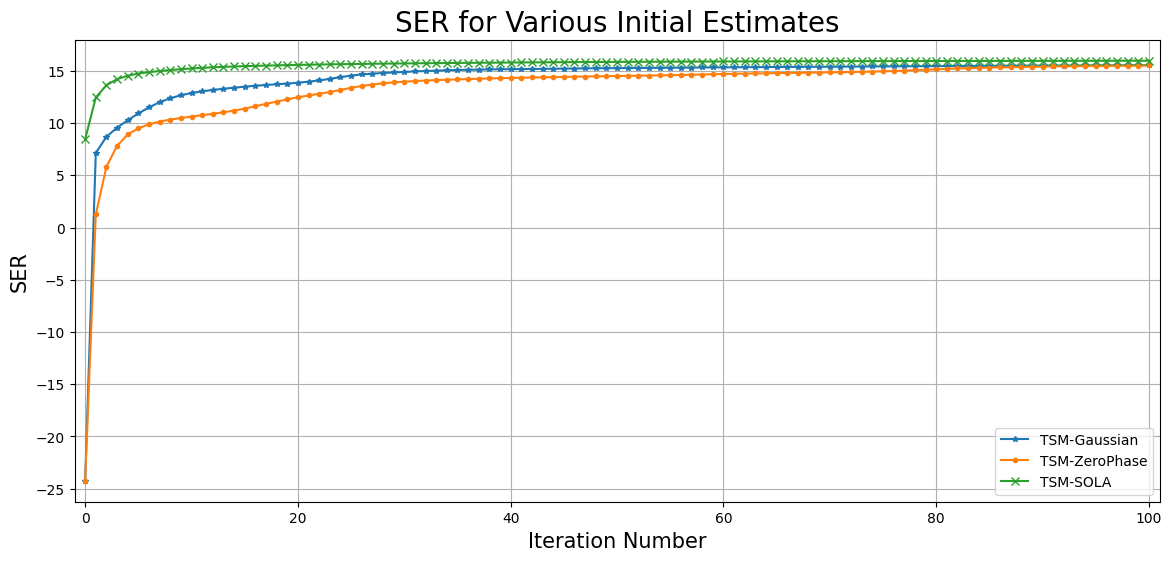

In [56]:
import matplotlib.pyplot as plt

iterations = list(range(len(ser_noise)))
ser_zp[0] = ser_noise[0] # ignore -infty values

plt.figure(figsize=(14, 6))
plt.plot(iterations, ser_noise, label='TSM-Gaussian', marker='*', markersize=4)
plt.plot(iterations, ser_zp, label='TSM-ZeroPhase', marker='o', markersize=3)
plt.plot(iterations, ser_sola, label='TSM-SOLA', marker='x')

plt.xlabel('Iteration Number', fontsize=15)
plt.ylabel('SER', fontsize=15)
plt.title('SER for Various Initial Estimates', fontsize=20)
plt.legend()
plt.xlim(-1, 101)
plt.grid(True)
plt.show()
